In [1]:
import numpy as np
import pandas as pd

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
from plot_functions import *
from sklearn.model_selection import KFold

In [3]:
from create_matrix import *
import os
from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
import sys


appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}
APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014




def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [4]:
n_splits = 10
case=2
cost='abs'

In [5]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [6]:
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df, sd_dfc)
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)

In [7]:
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse

In [8]:
iters = 1000
a = 3

In [64]:
H_series = {}
A_series = {}
T_series = {}
HAT_series = {}
cost_series = {}
HAT_au = {}

# As_au = {}

# H, As_au[2000], T = learn_HAT(case, au_tensor, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))
# H, As_au[4000], T = learn_HAT(case, au_tensor, a, a, num_iter=4000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))
# H, As_au[6000], T = learn_HAT(case, au_tensor, a, a, num_iter=6000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))
# H, As_au[8000], T = learn_HAT(case, au_tensor, a, a, num_iter=8000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))
# H, As_au[10000], T = learn_HAT(case, au_tensor, a, a, num_iter=10000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))

As_au_ada = {}
H, As_au_ada[100], T = learn_HAT_adagrad(case, au_tensor, a, a, num_iter=100, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))
H, As_au_ada[200], T = learn_HAT_adagrad(case, au_tensor, a, a, num_iter=200, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))
H, As_au_ada[500], T = learn_HAT_adagrad(case, au_tensor, a, a, num_iter=500, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))
H, As_au_ada[1000], T = learn_HAT_adagrad(case, au_tensor, a, a, num_iter=1000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))
H, As_au_ada[2000], T = learn_HAT_adagrad(case, au_tensor, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))
H, As_au_ada[4000], T = learn_HAT_adagrad(case, au_tensor, a, a, num_iter=4000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))
H, As_au_ada[6000], T = learn_HAT_adagrad(case, au_tensor, a, a, num_iter=6000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))


In [65]:
# for iters in [2000, 4000, 6000, 8000, 10000]:

#     H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_random_normal(case, sd_tensor, a, a, num_iter=10000, lr=0.1, dis=False, cost_function=cost,A_known = As_au[iters], T_known=np.ones(12).reshape(-1, 1))
    
#     H_series[iters] = Hs
#     A_series[iters] = As
#     T_series[iters] = Ts
#     HAT_series[iters] = HATs
#     cost_series[iters] = costs
for iters in [100, 200, 500, 1000, 2000, 4000, 6000]:

    H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_random_normal(case, sd_tensor, a, a, num_iter=3000, lr=0.1, dis=False, cost_function=cost,A_known = As_au_ada[iters], T_known=np.ones(12).reshape(-1, 1))
    
    H_series[iters] = Hs
    A_series[iters] = As
    T_series[iters] = Ts
    HAT_series[iters] = HATs
    cost_series[iters] = costs

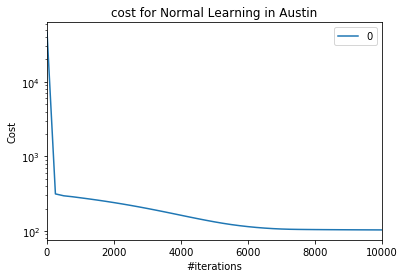

In [10]:
step=250
idx = np.arange(0, 3100, 250)

tdf = pd.DataFrame(costs_au[::step], index=idx)
tdf.plot(logy=True)
plt.title("cost for Normal Learning in Austin")
plt.ylabel("Cost")
plt.xlabel("#iterations")

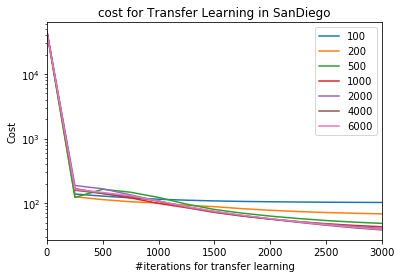

In [66]:
step=250
idx = np.arange(0, 3100, 250)
dfs = pd.DataFrame(cost_series[100][::step], index=idx, columns={str(100)})
for iters in [200, 500, 1000, 2000, 4000, 6000]:
    tdf = pd.DataFrame(cost_series[iters][::step], index=idx, columns={str(iters)})
    dfs = pd.concat([dfs, tdf], axis = 1)
dfs.plot(logy=True)
plt.title("cost for Transfer Learning in SanDiego")
plt.ylabel("Cost")
plt.xlabel("#iterations for transfer learning")

In [67]:
pred = {}   
        
for iters in [100,200, 500, 1000, 2000, 4000, 6000]:
    pred[iters] = {}
    for appliance in APPLIANCES_ORDER:
        pred[iters][appliance] = {f:[] for f in range(250, 3010, 250)}
        
for iters in [100,200, 500, 1000, 2000, 4000, 6000]:
    for iter_transfer in range(250, 3010, 250):
        for appliance_name, appliance_id in appliance_index.iteritems():
            pred[iters][appliance_name][iter_transfer].append(pd.DataFrame(HAT_series[iters][iter_transfer][:, appliance_id, :], index=sd_df.index))

In [68]:
from common import compute_rmse_fraction

out = {}

for iters in [100,200, 500, 1000, 2000, 4000, 6000]:
    out[iters] = {}    
    for appliance in APPLIANCES_ORDER[1:]:
        out[iters][appliance] = {}
        for f in range(250,3010, 250):
            s = pd.concat(pred[iters][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out[iters][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out[iters][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [69]:
pd_out = {}
for iters in [100, 200, 500, 1000, 2000, 4000, 6000]:
    pd_out[iters] = pd.DataFrame(out[iters])
    pd_out[iters] = pd_out[iters].rename( columns = 
                                         {'dw': "dw_" + str(iters),
                                          'wm': "wm_" + str(iters),
                                          'mw': "mw_" + str(iters),
                                          'oven': "oven_" + str(iters),
                                          'fridge': "fridge_"+ str(iters),
                                          'hvac': "hvac_" + str(iters)})

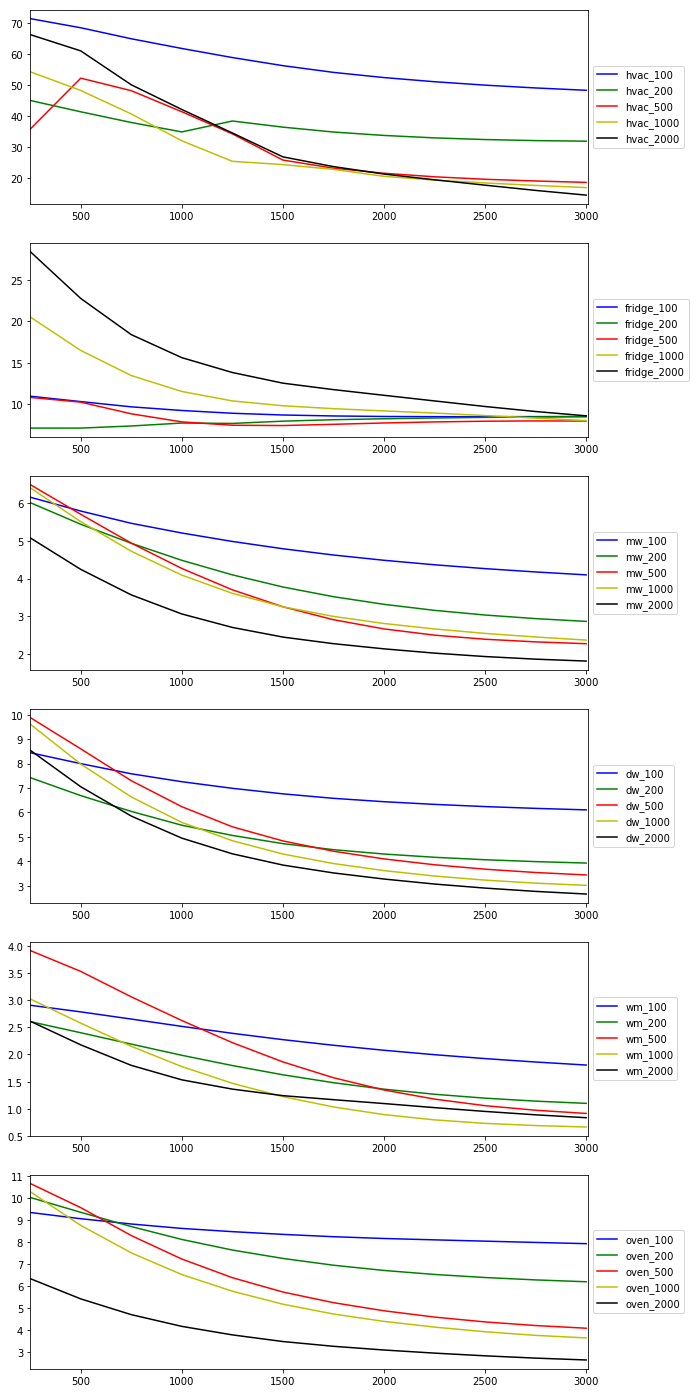

In [71]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 15))
ax = axes.flatten()
count = 0


# df['A'].plot(ax=axes[0,0]); axes[0,0].set_title('A')
for appliance in APPLIANCES_ORDER[1:]:
    dfs = {}
    num = 0
    for iters in [100,200, 500, 1000, 2000, 4000, 6000]:
        dfs[num] = pd_out[iters][appliance + "_" + str(iters)]
        num += 1
    df = pd.concat([dfs[0], dfs[1]], axis = 1)
    for i in range(2, 5):
        df = pd.concat([df, dfs[i]], axis = 1)

    pd.DataFrame(df).plot(ax=ax[count],figsize=(10, 25),xlim=(250, 3010), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#     ax[count].set_xlabel("iterations")
    count += 1
    
# plt.savefig("./analysis/0720/training_error.pdf", bbox_inches="tight", dpi=300, format="pdf")

### For Test error

In [17]:
case = 2
a = 3
iter_adapt = 3000

pred = {}
for iter_train in [100,200, 500, 1000, 2000, 4000, 6000]:
    pred[iter_train] = {}
    for random_seed in range(10):
        pred[iter_train][random_seed] = {}
        for appliance in APPLIANCES_ORDER:
            pred[iter_train][random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for iter_train in [100,200, 500, 1000, 2000, 4000, 6000]:
    print ("iter_train:", iter_train)
    for random_seed in range(10):
        print ("random_seed:", random_seed)
        for train_percentage in range(10, 110, 10):
            print ("train_percentage:", train_percentage)
            rd = 0
            for train_max, test in kf.split(sd_df):
                print ("rd:", rd)
                rd += 1

                num_train = int((train_percentage*len(train_max)/100)+0.5)
                if train_percentage==100:
                    train = train_max
                else:
                    train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
                train_ix = sd_df.index[train]
                test_ix = sd_df.index[test]

                num_test = len(test_ix)
                train_test_ix = np.concatenate([test_ix, train_ix])
                df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
                tensor = get_tensor(df_t, dfc_t)
                tensor_copy = tensor.copy()
                # First n
                tensor_copy[:num_test, 1:, :] = np.NaN

                H, A, T = learn_HAT(case, tensor_copy, a, a, num_iter=iter_adapt, lr=0.1, dis=False, cost_function=cost, A_known=As_au[iter_train], T_known=np.ones(12).reshape(-1, 1))

                HAT = multiply_case(H, A, T, case)
                for appliance in APPLIANCES_ORDER:
                    pred[iter_train][random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))

iter_train: 2000
random_seed: 0
train_percentage: 10
rd: 0


/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:35: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
train_percentage: 20
rd: 0
rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
train_percentage: 30
rd: 0
rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
train_percentage: 40
rd: 0
rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
train_percentage: 50
rd: 0
rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
train_percentage: 60
rd: 0
rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
train_percentage: 70
rd: 0
rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
train_percentage: 80
rd: 0
rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
train_percentage: 90
rd: 0
rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
train_percentage: 100
rd: 0
rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
random_seed: 1
train_percentage: 10
rd: 0
rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
train_percentage: 20
rd: 0
rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
train_percentage: 30
rd: 0
rd: 1
rd: 2


## Normal Learning in SanDiego

In [16]:
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)
static_au = au_df[['area','total_occupants','num_rooms']].copy()
static_au['area'] = static_au['area'].div(4000)
static_au['total_occupants'] = static_au['total_occupants'].div(8)
static_au['num_rooms'] = static_au['num_rooms'].div(8)
static_au = static_au.values

In [17]:
df, dfc = create_matrix_single_region("SanDiego", year)
tensor = get_tensor(df, dfc)
static_sd = df[['area','total_occupants','num_rooms']].copy()
static_sd['area'] = static_sd['area'].div(4000)
static_sd['total_occupants'] = static_sd['total_occupants'].div(8)
static_sd['num_rooms'] = static_sd['num_rooms'].div(8)
static_sd = static_sd.values

In [19]:
pred = {}
sd = {}
out = {}
n_splits = 10
NUM_RANDOM = 3
n_iter=1200
TRAIN_SPLITS = range(10, 110, 10)
case = 2
num_home=5

cost = 'l21'
algo = 'adagrad'
for static_fac in ['static',None]:
    if static_fac is None:
        H_known_Sd = None
    else:
        H_known_Sd = static_sd    
    np.random.seed(0)
    pred[static_fac] = {}
    for lam in [1e-3, 1e-2, 1e-1, 0, 1]:
        pred[static_fac][lam] = {}
        for a in range(3):

            pred[static_fac][lam][a] = {}
            for random_seed in range(NUM_RANDOM):
                pred[static_fac][lam][a][random_seed] = {}
                for appliance in APPLIANCES_ORDER:
                    pred[static_fac][lam][a][random_seed][appliance] = {f:[] for f in TRAIN_SPLITS}

            kf = KFold(n_splits=n_splits)
            for random_seed in range(NUM_RANDOM):

                for train_percentage in TRAIN_SPLITS:
                    print(lam, static_fac, a, random_seed,train_percentage)
                    for train_max, test in kf.split(df):

                        num_train = int((train_percentage*len(train_max)/100)+0.5)
                        if train_percentage==100:
                            train = train_max
                        else:
                            train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
                        train_ix = df.index[train]
                        test_ix = df.index[test]

                        num_test = len(test_ix)
                        train_test_ix = np.concatenate([test_ix, train_ix])
                        df_t, dfc_t = df.ix[train_test_ix], dfc.ix[train_test_ix]
                        tensor = get_tensor(df_t, dfc_t)
                        tensor_copy = tensor.copy()
                        # First n
                        tensor_copy[:num_test, 1:, :] = np.NaN
                        if static_fac is not None:
                            H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor_copy, num_home, a, num_iter=n_iter, lr=1, dis=False, cost_function=cost, H_known=H_known_Sd[np.concatenate([test, train])], penalty_coeff=lam)
                        else:
                            H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor_copy, num_home, a, num_iter=n_iter, lr=1, dis=False, cost_function=cost, penalty_coeff=lam)

                        HAT = multiply_case(H, A, T, case)
                        for appliance in APPLIANCES_ORDER:
                            pred[static_fac][lam][a][random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))


0.001 static 0 0 10
0.001 static 0 0 20
0.001 static 0 0 30
0.001 static 0 0 40
0.001 static 0 0 50
0.001 static 0 0 60
0.001 static 0 0 70
0.001 static 0 0 80
0.001 static 0 0 90
0.001 static 0 0 100
0.001 static 0 1 10
0.001 static 0 1 20
0.001 static 0 1 30
0.001 static 0 1 40
0.001 static 0 1 50
0.001 static 0 1 60
0.001 static 0 1 70
0.001 static 0 1 80
0.001 static 0 1 90
0.001 static 0 1 100
0.001 static 0 2 10
0.001 static 0 2 20
0.001 static 0 2 30
0.001 static 0 2 40
0.001 static 0 2 50
0.001 static 0 2 60
0.001 static 0 2 70
0.001 static 0 2 80
0.001 static 0 2 90
0.001 static 0 2 100
0.001 static 1 0 10
0.001 static 1 0 20
0.001 static 1 0 30
0.001 static 1 0 40
0.001 static 1 0 50
0.001 static 1 0 60
0.001 static 1 0 70
0.001 static 1 0 80
0.001 static 1 0 90
0.001 static 1 0 100
0.001 static 1 1 10
0.001 static 1 1 20
0.001 static 1 1 30
0.001 static 1 1 40
0.001 static 1 1 50
0.001 static 1 1 60
0.001 static 1 1 70
0.001 static 1 1 80
0.001 static 1 1 90
0.001 static 1 1

KeyboardInterrupt: 

In [10]:
import pickle
from common import compute_rmse_fraction


pred = {}
pred['normal'] = {}
pred['transfer'] = {}
for iterations in [100, 500, 1000, 1500]:
    pred['transfer'][iterations] = {}
    for static_fac in['static', 'None']:
        pred['transfer'][iterations][static_fac] = {}
        for lam in [0.001, 0.01, 0.1, 0, 1]:
            lam = float(lam)
            pred['transfer'][iterations][static_fac][lam] = {}
            for random_seed in range(10):
                print (iterations, lam, random_seed)
                pred['transfer'][iterations][static_fac][lam][random_seed] = load_obj('pred_adagrad/pred_transfer_' + str(iterations) + "_" + static_fac + "_" + str(lam) + "_" + str(random_seed) +"_const")

for static_fac in['static', 'None']:
    pred['normal'][static_fac] = {}
    for lam in [0.001, 0.01, 0.1, 0, 1]:
        lam = float(lam)
        pred['normal'][static_fac][lam] = {}
        for random_seed in range(10):
            print (lam, random_seed)
            pred['normal'][static_fac][lam][random_seed] = load_obj('pred_adagrad/pred_normal_' + static_fac + "_" + str(lam) + "_" + str(random_seed) + "_const")

100 0.001 0
100 0.001 1
100 0.001 2
100 0.001 3
100 0.001 4
100 0.001 5
100 0.001 6
100 0.001 7
100 0.001 8
100 0.001 9
100 0.01 0
100 0.01 1
100 0.01 2
100 0.01 3
100 0.01 4
100 0.01 5
100 0.01 6
100 0.01 7
100 0.01 8
100 0.01 9
100 0.1 0
100 0.1 1
100 0.1 2
100 0.1 3
100 0.1 4
100 0.1 5
100 0.1 6
100 0.1 7
100 0.1 8
100 0.1 9
100 0.0 0
100 0.0 1
100 0.0 2
100 0.0 3
100 0.0 4
100 0.0 5
100 0.0 6
100 0.0 7
100 0.0 8
100 0.0 9
100 1.0 0
100 1.0 1
100 1.0 2
100 1.0 3
100 1.0 4
100 1.0 5
100 1.0 6
100 1.0 7
100 1.0 8
100 1.0 9
100 0.001 0
100 0.001 1
100 0.001 2
100 0.001 3
100 0.001 4
100 0.001 5
100 0.001 6
100 0.001 7
100 0.001 8
100 0.001 9
100 0.01 0
100 0.01 1
100 0.01 2
100 0.01 3
100 0.01 4
100 0.01 5
100 0.01 6
100 0.01 7
100 0.01 8
100 0.01 9
100 0.1 0
100 0.1 1
100 0.1 2
100 0.1 3
100 0.1 4
100 0.1 5
100 0.1 6
100 0.1 7
100 0.1 8
100 0.1 9
100 0.0 0
100 0.0 1
100 0.0 2
100 0.0 3
100 0.0 4
100 0.0 5
100 0.0 6
100 0.0 7
100 0.0 8
100 0.0 9
100 1.0 0
100 1.0 1
100 1.0 2
100 1.0 3


In [9]:
def load_obj(name):
    with open(os.path.expanduser('~/git/' + name + '.pkl'), 'rb') as f:
        return pickle.load(f)

In [16]:
out = {}
out['normal'] = {}
out['transfer'] = {}

for iter_train in [100,500,1000,1500]:
    out['transfer'][iter_train] = {}
    for static_fac in ['static', 'None']:
        out['transfer'][iter_train][static_fac] = {}
        for lam in [0.001, 0.01, 0.1, 0, 1]:
            lam = float(lam)
            out['transfer'][iter_train][static_fac][lam] = load_obj('out_adagrad/out_transfer_' + str(iter_train) + '_' + static_fac + "_" + str(lam)+ "_const")
#             for random_seed in range(10):
#                 print (iter_train, static_fac, lam, random_seed)
#                 out['transfer'][iter_train][static_fac][lam][random_seed] = {}
#                 for appliance in APPLIANCES_ORDER[1:]:
#                     out['transfer'][iter_train][static_fac][lam][random_seed][appliance] = {}
#                     for f in range(10,110,10):
#                         s = pd.concat(pred['transfer'][iter_train][static_fac][lam][random_seed][appliance][f]).ix[sd_df.index]
#                         if appliance=="hvac":
#                             out['transfer'][iter_train][static_fac][lam][random_seed][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
#                         else:   
#                             out['transfer'][iter_train][static_fac][lam][random_seed][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]
        
out['normal'][0] = {}
for static_fac in ['static', 'None']:
    out['normal'][0][static_fac] = {}
    for lam in [0.001, 0.01, 0.1, 0, 1]:
        lam = float(lam)
        out['normal'][0][static_fac][lam] = load_obj('out_adagrad/out_normal_' + static_fac + "_" + str(lam) + "_const")
#         for random_seed in range(10):
#             print (static_fac, lam, random_seed)
#             out['normal'][0][static_fac][lam][random_seed] = {}
#             for appliance in APPLIANCES_ORDER[1:]:
#                 out['normal'][0][static_fac][lam][random_seed][appliance] = {}
#                 for f in range(10,110,10):
#                     s = pd.concat(pred['normal'][static_fac][lam][random_seed][appliance][f]).ix[sd_df.index]
#                     if appliance=="hvac":
#                         out['transfer'][0][static_fac][lam][random_seed][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
#                     else:   
#                         out['transfer'][0][static_fac][lam][random_seed][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]


In [17]:
mean_out = {}
mean_out['transfer'] = {}

for iters in [100, 500, 1000, 1500]:
    mean_out['transfer'][iters] = {}
    for static_fac in ['static', 'None']:
        mean_out['transfer'][iters][static_fac] = {}
        for lam in [0.001, 0.01, 0.1, 0, 1]:
            lam = float(lam)
            mean_out['transfer'][iters][static_fac][lam] = pd.Panel(out['transfer'][iters][static_fac][lam]).mean(axis=0)

mean_out['normal'] = {}
mean_out['normal'][0] = {}
for static_fac in ['static', 'None']:
    mean_out['normal'][0][static_fac] = {}
    for lam in [0.001, 0.01, 0.1, 0, 1]:
        lam = float(lam)
        mean_out['normal'][0][static_fac][lam] = pd.Panel(out['normal'][0][static_fac][lam]).mean(axis=0)

In [21]:
df_out = {}
df_out['transfer'] = {}
for iters in [100, 500, 1000, 1500]:
    df_out['transfer'][iters] = {}
    for static_fac in ['static', 'None']:
        df_out['transfer'][iters][static_fac] = {}
        for lam in [0.001, 0.01, 0.1, 0, 1]:
            lam = float(lam)
            df_out['transfer'][iters][static_fac][lam] = pd.DataFrame(mean_out['transfer'][iters][static_fac][lam])
            df_out['transfer'][iters][static_fac][lam] = df_out['transfer'][iters][static_fac][lam].rename(columns=
                                        {'dw': "dw_transfer_" + str(iters) +"_"+static_fac+"_"+str(lam),
                                          'wm': "wm_transfer_" + str(iters)+"_"+static_fac+"_"+str(lam),
                                          'mw': "mw_transfer_" + str(iters)+"_"+static_fac+"_"+str(lam),
                                          'oven': "oven_transfer_" + str(iters)+"_"+static_fac+"_"+str(lam),
                                          'fridge': "fridge_transfer_"+ str(iters)+"_"+static_fac+"_"+str(lam),
                                          'hvac': "hvac_transfer_" + str(iters)+"_"+static_fac+"_"+str(lam)})
df_out['normal'] = {}
df_out['normal'][0] = {}
for static_fac in ['static', 'None']:
    df_out['normal'][0][static_fac] = {}
    for lam in [0.001, 0.01, 0.1, 0, 1]:
        lam = float(lam)
        df_out['normal'][0][static_fac][lam] = pd.DataFrame(mean_out['normal'][0][static_fac][lam])
        df_out['normal'][0][static_fac][lam] = df_out['normal'][0][static_fac][lam].rename(columns=
                                        {'dw': "dw_normal_" +static_fac+"_"+str(lam),
                                          'wm': "wm_normal_" +static_fac+"_"+str(lam),
                                          'mw': "mw_normal_" +static_fac+"_"+str(lam),
                                          'oven': "oven_normal_" +static_fac+"_"+str(lam),
                                          'fridge': "fridge_normal_"+static_fac+"_"+str(lam),
                                          'hvac': "hvac_normal_"+static_fac+"_"+str(lam)})

In [26]:
df_out['transfer'][100]['static'][0.1]

,dw_transfer_100_static_0.1,fridge_transfer_100_static_0.1,hvac_transfer_100_static_0.1,mw_transfer_100_static_0.1,oven_transfer_100_static_0.1,wm_transfer_100_static_0.1
10,1.896393,11.767234,30.041694,2.884072,3.157430,0.905136
20,1.877206,11.269829,28.409363,2.884072,3.086605,0.851368
30,1.877971,11.113154,27.075837,2.884072,3.067554,0.843788
40,1.872924,11.094070,27.166203,2.884072,3.052988,0.848336
50,1.868653,11.138404,28.340599,2.884072,3.056345,0.849997
60,1.866312,11.068105,27.591809,2.884072,3.045731,0.848678
70,1.862791,11.094025,27.942809,2.884072,3.046555,0.850615
80,1.860857,10.979300,26.848748,2.884072,3.028782,0.841226
90,1.860767,10.936746,26.011362,2.884072,3.023309,0.841932
100,1.833493,10.864302,25.180374,2.884072,3.020217,0.822372


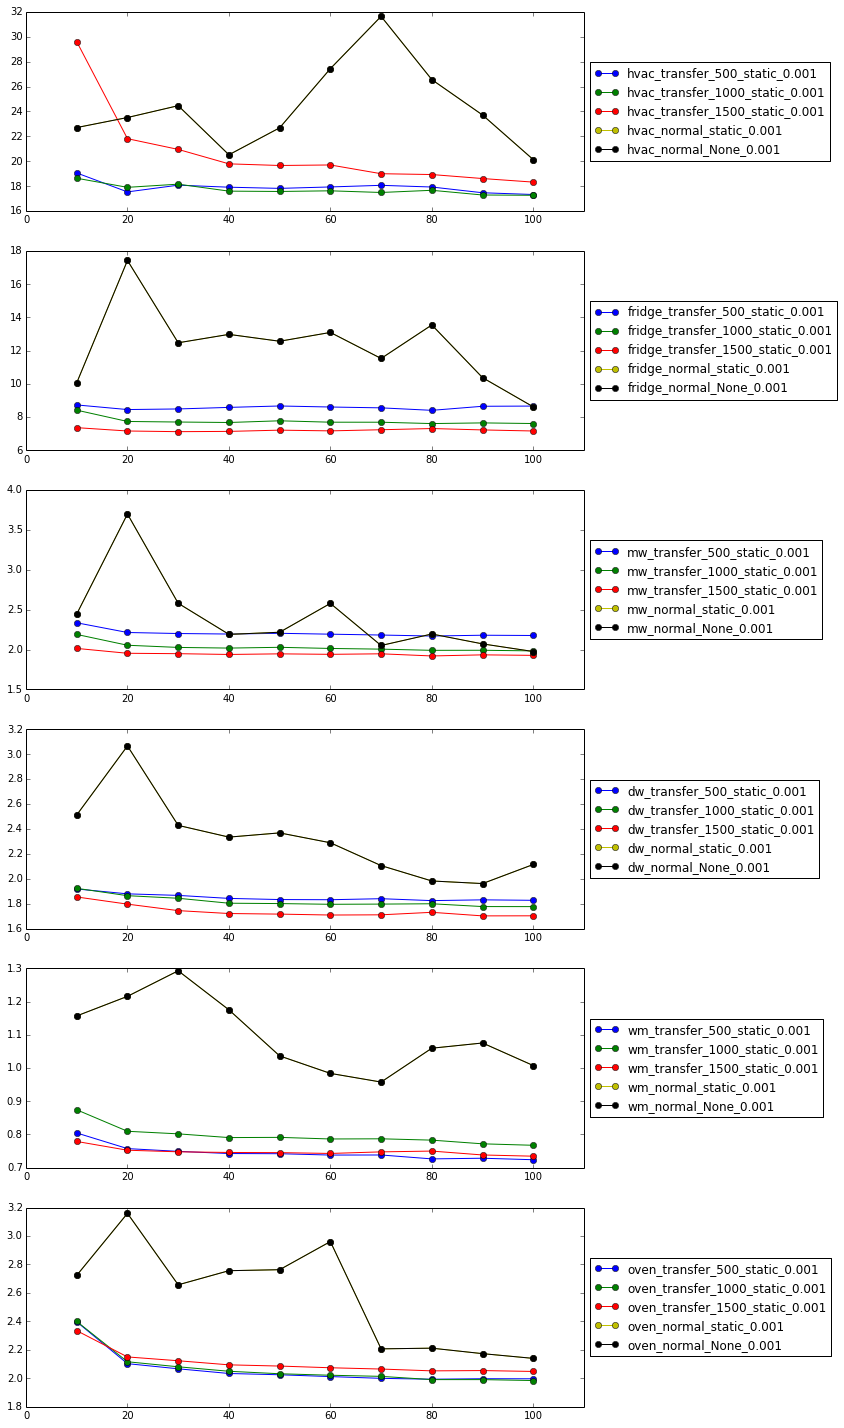

In [34]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 15))
ax = axes.flatten()
count = 0


# df['A'].plot(ax=axes[0,0]); axes[0,0].set_title('A')
for appliance in APPLIANCES_ORDER[1:]:
    dfs = {}
    num = 0
    
    for iters in [100, 500, 1000, 1500]:
        for static_fac in ['static', 'None']:
            for lam in [0.001, 0.01, 0.1, 0, 1]:
                lam = float(lam)
                dfs[num] = df_out['transfer'][iters][static_fac][lam][appliance+"_transfer_" + str(iters) +"_"+static_fac+"_"+str(lam)]
                num+=1
    for static_fac in ['static', 'None']:
        for lam in [0.001, 0.01, 0.1, 0, 1]:
            lam = float(lam)
            dfs[num] = df_out['normal'][0][static_fac][lam][appliance+"_normal_"+static_fac+"_"+str(lam)]
            num+=1
    
    
    
    df = pd.concat([dfs[10], dfs[20], dfs[30], dfs[40], dfs[45]], axis = 1)
#     for i in range(1, 1):
#         df = pd.concat([df, dfs[i]], axis = 1)

    pd.DataFrame(df).plot(ax=ax[count],figsize=(10, 25), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    count += 1
# plt.savefig("./analysis/0720/adagrad_test_error.pdf", bbox_inches="tight", dpi=300, format="pdf")

### Normal learning in Austin

In [118]:
n_splits = 10
case = 2
a = 3
b = 3
c = 1
cost = 'abs'
pred_normal_au = {}

for random_seed in range(10):
    
    pred_normal_au[random_seed] = {}
#     T_normal_const[random_seed] = {}
#     A_normal_const[random_seed] = {}
#     H_normal_const[random_seed] = {}
    
    
    for appliance in APPLIANCES_ORDER:
        pred_normal_au[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for random_seed in range(10):
    print ('random seed: ', random_seed)
    for train_percentage in range(10, 110, 10):
        print ('training percentage: ', train_percentage)
        rd = 0
        
#         T_normal_const[random_seed][train_percentage] = {}
#         A_normal_const[random_seed][train_percentage] = {}
#         H_normal_const[random_seed][train_percentage] = []
        
        for train_max, test in kf.split(au_df):
            print ('round: ', rd)
           
            
            num_train = int((train_percentage*len(train_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if train_percentage==100:
                train = train_max
            else:
                train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
            
            # get the index of training and testing data
            train_ix = au_df.index[train]
            test_ix = au_df.index[test]
            print ('test_ix: ', test_ix)
            
            # create the tensor
            train_test_ix = np.concatenate([test_ix, train_ix])
            df_t, dfc_t = au_df.ix[train_test_ix], au_dfc.ix[train_test_ix]
            tensor = get_tensor(df_t, dfc_t)
            
            ############################################################################################
            # Normal learning: no constant constraint, no A_known, with learn_HAT
            ############################################################################################
#             tensor_copy = tensor.copy()
#             tensor_copy[:num_test, 1:, :] = np.NaN
#             H, A, T = learn_HAT(case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost)
#             T_normal[random_seed][train_percentage][rd] = T
#             A_normal[random_seed][train_percentage][rd] = A
#             H_normal[random_seed][train_percentage].append(H)
            
#             # get the prediction
#             HAT = multiply_case(H, A, T, case)
#             for appliance in APPLIANCES_ORDER:
#                 pred_normal[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
            
            
            ############################################################################################
            # Normal learning with constant: with constant, no A_known, with learn_HAT_constant
            ############################################################################################
            tensor_copy = tensor.copy()
            tensor_copy[:num_test, 1:, :] = np.NaN
            H, A, T = learn_HAT(case, tensor_copy, a, b, num_iter=3000, lr=0.1, dis=False, cost_function=cost, T_known = np.ones(12).reshape(-1, 1))
#             T_normal_const[random_seed][train_percentage][rd] = T
#             A_normal_const[random_seed][train_percentage][rd] = A
#             H_normal_const[random_seed][train_percentage].append(H)
            
            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred_normal_au[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
            
            
            ############################################################################################
            # transfer learning: no constant constraint, with A_known = A_a, with learn_HAT
            ############################################################################################
#             tensor_copy = tensor.copy()
#             tensor_copy[:num_test, 1:, :] = np.NaN
#             H, A, T = learn_HAT(case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_a)
#             T_transfer[random_seed][train_percentage][rd] = T
#             A_transfer[random_seed][train_percentage][rd] = A
#             H_transfer[random_seed][train_percentage].append(H)
            
#             # get the prediction
#             HAT = multiply_case(H, A, T, case)
#             for appliance in APPLIANCES_ORDER:
#                 pred_transfer[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
            
            
            ############################################################################################
            # transfer learning: constant constraint, with A_known = A_a_const, with learn_HAT_constant
            ############################################################################################
#             tensor_copy = tensor.copy()
#             tensor_copy[:num_test, 1:, :] = np.NaN
#             H, A, T = learn_HAT_constant(c, case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_a_const)
#             T_transfer_const[random_seed][train_percentage][rd] = T
#             A_transfer_const[random_seed][train_percentage][rd] = A
#             H_transfer_const[random_seed][train_percentage].append(H)
            
#             # get the prediction
#             HAT = multiply_case(H, A, T, case)
#             for appliance in APPLIANCES_ORDER:
#                 pred_transfer_const[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
            
            
            rd += 1

random seed:  0
training percentage:  10
round:  0
test_ix:  Int64Index([ 22,  26,  48,  59,  68,  77,  86,  93,  94, 101, 114, 115, 121,
            130, 135, 160, 171, 187, 222, 243, 252, 267, 297, 347, 364, 370,
            410, 434, 436, 457, 470, 484, 491, 499, 503, 507, 508, 545, 555,
            580, 585, 624, 645, 661, 668, 739, 744, 772, 781, 861, 871, 878,
            890, 898],
           dtype='int64')
round:  1
test_ix:  Int64Index([ 936,  946,  954,  974,  980,  994, 1037, 1069, 1086, 1103, 1105,
            1153, 1169, 1185, 1192, 1202, 1283, 1310, 1314, 1331, 1334, 1403,
            1415, 1463, 1464, 1479, 1500, 1507, 1508, 1551, 1577, 1586, 1589,
            1601, 1617, 1632, 1642, 1681, 1697, 1700, 1714, 1718, 1782, 1790,
            1791, 1792, 1796, 1800, 1801, 1854, 1889, 1947, 1953, 1994],
           dtype='int64')
round:  2
test_ix:  Int64Index([2004, 2018, 2034, 2072, 2075, 2094, 2129, 2156, 2158, 2171, 2199,
            2207, 2233, 2242, 2247, 2335, 2337, 2360,

KeyboardInterrupt: 